In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/formula-1-world-championship-1950-2020'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv


In [60]:
results = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/results.csv")
races = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/races.csv")
status = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/status.csv")
drivers = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv")
constructors = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv")

In [61]:
drivers['driverLabel'] = drivers['driverId'].astype(str) + " - " + drivers['surname']

# Merge for reliability analysis
results = results.merge(races[['raceId', 'year', 'name']], on='raceId')
results = results.merge(status, on='statusId')
results = results.merge(drivers[['driverId', 'driverLabel']], on='driverId')

# Feature: positions lost/gained
results['positions_lost'] = results['grid'] - results['positionOrder']

# Feature: DNF indicator
results['DNF'] = results['status'].apply(lambda x: 1 if x not in ['Finished', 'Lap', 'Disqualified'] else 0)

constructors['constructorLabel'] = constructors['constructorId'].astype(str) + " - " + constructors['name']
results = results.merge(constructors[['constructorId','constructorLabel']], on='constructorId')

driverLabel
1 - Hamilton        4820.5
20 - Vettel         3098.0
830 - Verstappen    2912.5
4 - Alonso          2329.0
8 - Räikkönen       1873.0
822 - Bottas        1788.0
3 - Rosberg         1594.5
815 - Pérez         1585.0
30 - Schumacher     1566.0
844 - Leclerc       1363.0
Name: points, dtype: float64


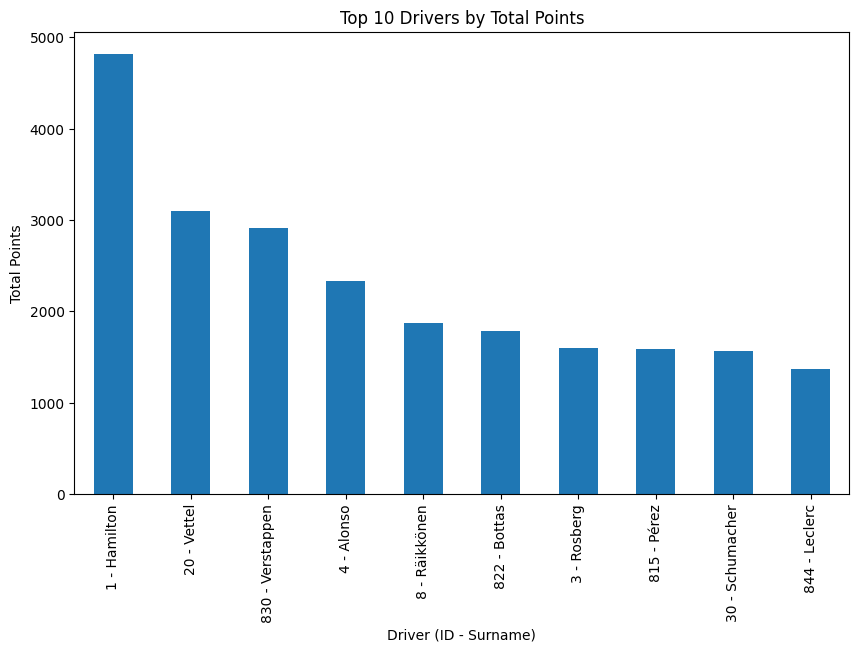

In [62]:
top_drivers = (results.groupby('driverLabel')['points']
               .sum()
               .sort_values(ascending=False)
               .head(10))

print(top_drivers)
plt.figure(figsize=(10,6))
top_drivers.plot(kind='bar')
plt.title("Top 10 Drivers by Total Points")
plt.xlabel("Driver (ID - Surname)")
plt.ylabel("Total Points")
plt.show()


/tmp/ipykernel_36/125144175.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['points'].sum() / len(x))


constructorLabel
131 - Mercedes          11.856810
9 - Red Bull             9.737310
23 - Brawn               5.058824
208 - Lotus F1           4.584416
6 - Ferrari              4.547466
211 - Racing Point       3.723684
1 - McLaren              3.651846
196 - Matra-Ford         3.250000
214 - Alpine F1 Team     2.766667
10 - Force India         2.589623
dtype: float64


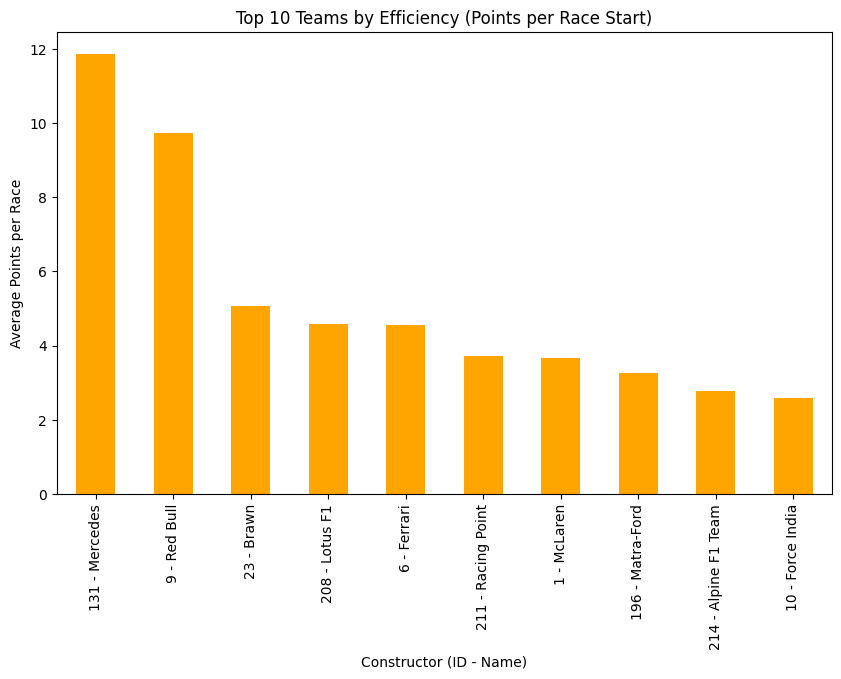

In [63]:
team_efficiency = (results.groupby('constructorLabel')
                   .apply(lambda x: x['points'].sum() / len(x))
                   .sort_values(ascending=False)
                   .head(10))

print(team_efficiency)
plt.figure(figsize=(10,6))
team_efficiency.plot(kind='bar', color='orange')
plt.title("Top 10 Teams by Efficiency (Points per Race Start)")
plt.xlabel("Constructor (ID - Name)")
plt.ylabel("Average Points per Race")
plt.show()


year
1989    546
1991    453
1990    449
1988    419
1992    409
       ... 
1950    143
1969    138
1957    136
2023    134
2009    125
Name: DNF, Length: 75, dtype: int64


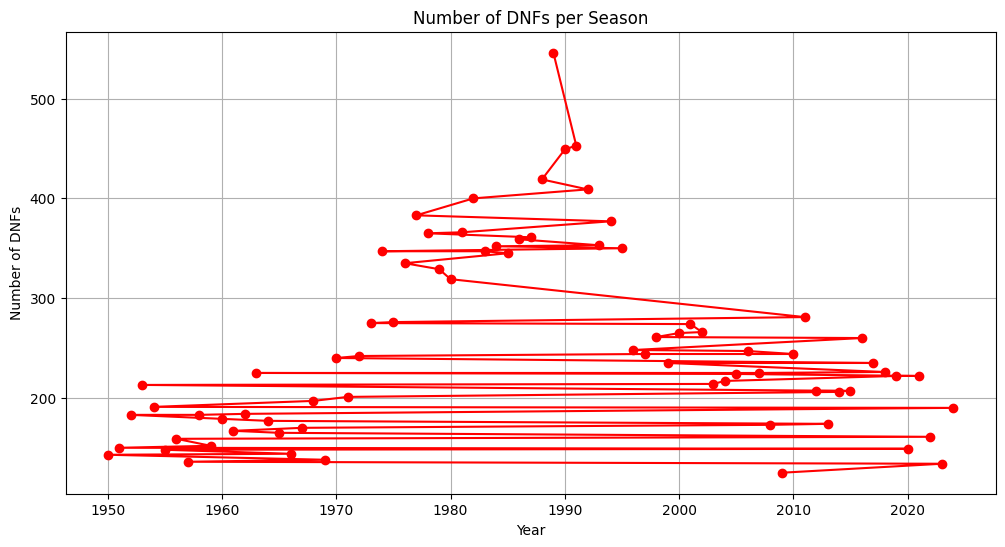

status
+1 Lap             4037
Engine             2026
+2 Laps            1613
Accident           1062
Did not qualify    1025
Collision           854
Gearbox             810
Spun off            795
+3 Laps             731
Suspension          431
Name: count, dtype: int64


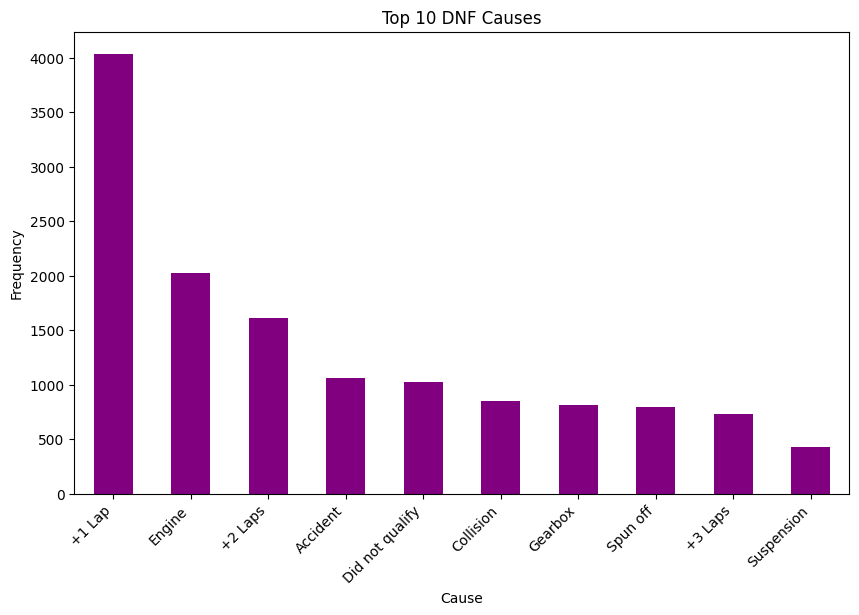

In [64]:
dnf_by_year = results.groupby('year')['DNF'].sum().sort_values(ascending=False)
print(dnf_by_year)

plt.figure(figsize=(12,6))
dnf_by_year.plot(kind='line', marker='o', color='red')
plt.title("Number of DNFs per Season")
plt.xlabel("Year")
plt.ylabel("Number of DNFs")
plt.grid(True)
plt.show()

# Top 10 DNF causes
dnf_causes = results[results['DNF'] == 1]['status'].value_counts().head(10)
print(dnf_causes)

plt.figure(figsize=(10,6))
dnf_causes.plot(kind='bar', color='purple')
plt.title("Top 10 DNF Causes")
plt.xlabel("Cause")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.show()


driverLabel
156 - Palmer        409
63 - Salo           280
176 - Surer         269
69 - Badoer         252
64 - Diniz          245
166 - Streiff       242
50 - Verstappen     223
48 - Gené           213
828 - Ericsson      186
104 - Fittipaldi    172
Name: positions_lost, dtype: int64


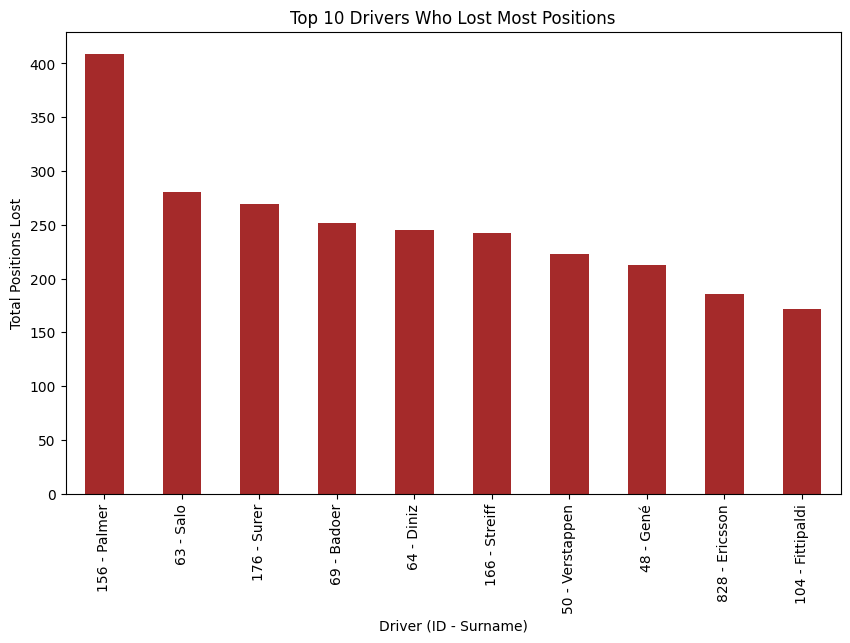

In [65]:
worst_performers = (results.groupby('driverLabel')['positions_lost']
                    .sum()
                    .sort_values(ascending=False)
                    .head(10))

print(worst_performers)
plt.figure(figsize=(10,6))
worst_performers.plot(kind='bar', color='brown')
plt.title("Top 10 Drivers Who Lost Most Positions")
plt.xlabel("Driver (ID - Surname)")
plt.ylabel("Total Positions Lost")
plt.show()


/tmp/ipykernel_36/1014255533.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_by_decade = era_performance.groupby('decade').apply(


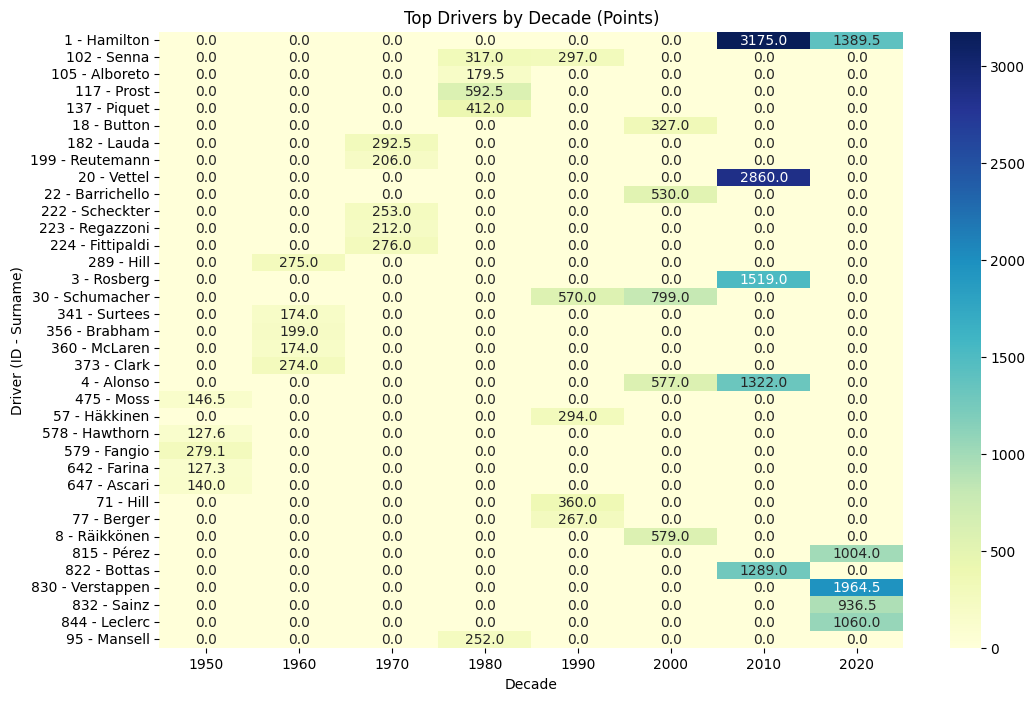

In [66]:
results['decade'] = (results['year'] // 10) * 10
era_performance = (results.groupby(['decade', 'driverLabel'])['points']
                   .sum()
                   .reset_index())

# Top 5 per decade
top_by_decade = era_performance.groupby('decade').apply(
    lambda x: x.sort_values('points', ascending=False).head(5)).reset_index(drop=True)

# Heatmap pivot
heatmap_data = top_by_decade.pivot_table(values='points', index='driverLabel', columns='decade', fill_value=0)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Top Drivers by Decade (Points)")
plt.xlabel("Decade")
plt.ylabel("Driver (ID - Surname)")
plt.show()
